## **Device Activations Challenge**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import combinations
from scipy import signal

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import shap

import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go

pyo.init_notebook_mode()

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data/device_activations.csv", parse_dates=["time"])

In [3]:
df

time    device  device_activated
0    2016-07-01 04:23:32  device_6                 1
1    2016-07-01 06:52:57  device_2                 1
2    2016-07-01 06:53:00  device_2                 1
3    2016-07-01 06:56:41  device_2                 1
4    2016-07-01 07:00:01  device_6                 1
...                  ...       ...               ...
9040 2016-08-31 17:26:23  device_6                 1
9041 2016-08-31 17:34:34  device_4                 1
9042 2016-08-31 17:34:42  device_6                 1
9043 2016-08-31 17:40:03  device_4                 1
9044 2016-08-31 17:50:03  device_6                 1

[9045 rows x 3 columns]

In [4]:
df.time.min()

Timestamp('2016-07-01 04:23:32')

In [5]:
df.time.max()

Timestamp('2016-08-31 17:50:03')

The data consists on timestamps, device and device_activated, the number of times each device was activated.

The objective of the challenge is to predict the next 24 hours individually, a predictions for 9:00 AM, 10:00 AM, and so on until 23:00PM the last timestamp of each day.

We have seven diff devices, so every operation/agg/etc I do here, has to take into account the device.

My approach to this problem is to aggregate the data at the time and device lvl, and then classify the points into positive, i.e. the light will be on and negative the light will be switched off.

To do this, I will need to:

1. Aggregate at the time and device level summing up device_activated
2. FIll in the gaps of the time column at the hour **and device** lvl and label them as 0;
3. Create features (this data is very interesting to test one imagination to create features)
4. evaluate
5. reproduce the given script

So I aggregate the data

In [6]:
dfagg = df.set_index('time').groupby([pd.Grouper(freq='H'), 'device']).sum().reset_index()

In [7]:
dfagg

time    device  device_activated
0    2016-07-01 04:00:00  device_6                 1
1    2016-07-01 06:00:00  device_2                 3
2    2016-07-01 07:00:00  device_2                12
3    2016-07-01 07:00:00  device_4                 4
4    2016-07-01 07:00:00  device_6                 6
...                  ...       ...               ...
1962 2016-08-31 16:00:00  device_2                 9
1963 2016-08-31 16:00:00  device_4                 4
1964 2016-08-31 16:00:00  device_6                 6
1965 2016-08-31 17:00:00  device_4                 3
1966 2016-08-31 17:00:00  device_6                 4

[1967 rows x 3 columns]

In [8]:
dfagg["time"] = pd.to_datetime(dfagg["time"])

Create all timestamps between the maximum and minimum ts (min and max above)...

In [9]:
all_ts = pd.date_range("2016-07-01 00:00:00", "2016-08-31 23:00:00", freq="H")

In [10]:
all_ts

DatetimeIndex(['2016-07-01 00:00:00', '2016-07-01 01:00:00',
               '2016-07-01 02:00:00', '2016-07-01 03:00:00',
               '2016-07-01 04:00:00', '2016-07-01 05:00:00',
               '2016-07-01 06:00:00', '2016-07-01 07:00:00',
               '2016-07-01 08:00:00', '2016-07-01 09:00:00',
               ...
               '2016-08-31 14:00:00', '2016-08-31 15:00:00',
               '2016-08-31 16:00:00', '2016-08-31 17:00:00',
               '2016-08-31 18:00:00', '2016-08-31 19:00:00',
               '2016-08-31 20:00:00', '2016-08-31 21:00:00',
               '2016-08-31 22:00:00', '2016-08-31 23:00:00'],
              dtype='datetime64[ns]', length=1488, freq='H')

Multiply by the nb of devices...

In [11]:
unique_devices = sorted(df.device.unique())

In [12]:
len(all_ts) * len(unique_devices)

10416

So at the end of merging the positive and the negative devices, I **must** have **10416** observations, **1488** observations per device.

In [13]:
df_dict = dict()

In [14]:
unique_devices

['device_1',
 'device_2',
 'device_3',
 'device_4',
 'device_5',
 'device_6',
 'device_7']

In [15]:
df_final = dfagg.copy()

for dev in unique_devices:
    
    print(dev)
    df_dict[f"{dev}"] = {}
    
    data_ts = dfagg[dfagg["device"] == dev]
    
    data_ts["time"] = pd.to_datetime(data_ts["time"])
    
    data_ts_values = data_ts["time"].tolist()

    print(len(set(data_ts_values)))
    
    df_dict[f"{dev}"]["diff"] = list(set(all_ts).difference(set(data_ts_values)))
    df_dict[f"{dev}"]["len_diff"] = len(df_dict[f"{dev}"]["diff"])
    
    df_dict[f"{dev}"]["data"] = pd.DataFrame(data=zip([dev]*df_dict[f"{dev}"]["len_diff"], df_dict[f"{dev}"]["diff"]), columns=["device", "time"]).assign(device_activated = 0)
    
    df_final = pd.concat([df_final, df_dict[f"{dev}"]["data"]])


device_1
218
device_2
388
device_3
233
device_4
276
device_5
297
device_6
489
device_7
66




From the start I wanted to have an idea of the data. The code above could be a little bit too verbose, but I think it's interesting to understand what devices if any are more affected then others. This could lead to the predictions for a specific device to be more difficult for lack of data.

We can see that **`device_7`** only has 66 positive points, curious to check if the model will indicate something related to this specific device.




### **Exploration**

So obviously this dataset consists of 7 different time series. I imagine each device will be different or very similar (highly correlated? how to measure correlation in a time series? taking into account the lags?)


For this I used plotly, I think its much easier, as one plot is enough to show the different time series

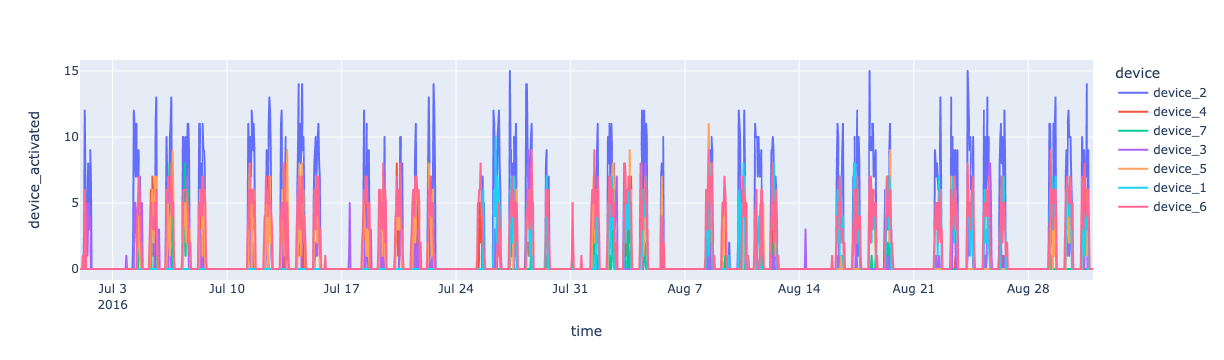

In [16]:
fig = px.line(df_final.sort_values(["time"]), x='time', y="device_activated", color="device",
              line_group="device")
fig.show()

So lets use at `device_3`, as is somewhat rich in terms of positive labelled instances:

- We have data for the complete range of dates (as expected);
- We still ahve some variability, its not an ARIMA kind of time-serie -- some days are only on during the morning (interesting feature), sometimes until the entire business hour pattern;


So lets use at `device_6`, as is somewhat rich in terms of positive labelled instances:

- We have data for the complete range of dates (as expected);
- Perfect time-series, clear seasonality (SARIMA model), 8:00 AM to 17:00 PM


So lets use at `device_7`, as is poor in terms of positive labelled instances:

- A couple of gaps along the original span of the series;
- inconsistent pattern

To visualize better, I still ran a decomposition algorithm to vizualise it better and also think about features...

Decompostion for device: device_1
Observed


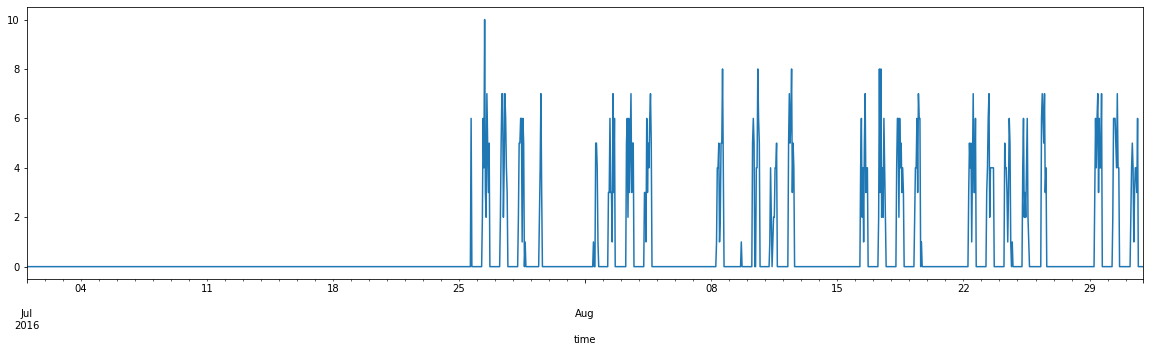

Trend


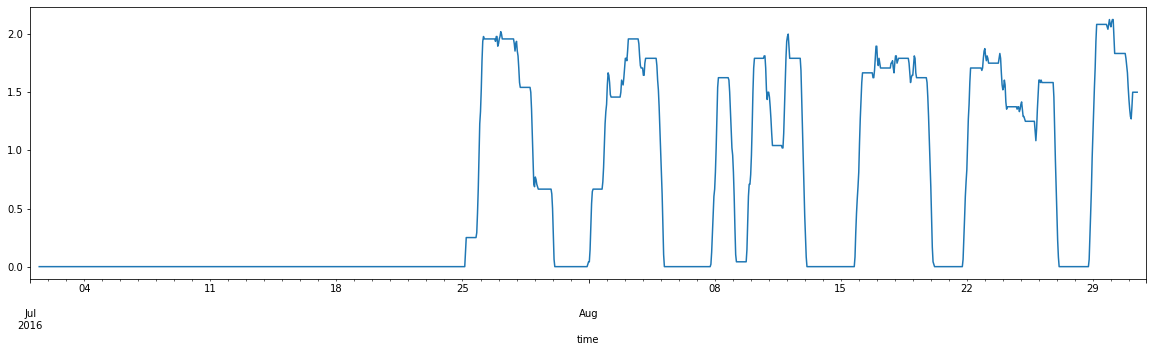

Seasonality


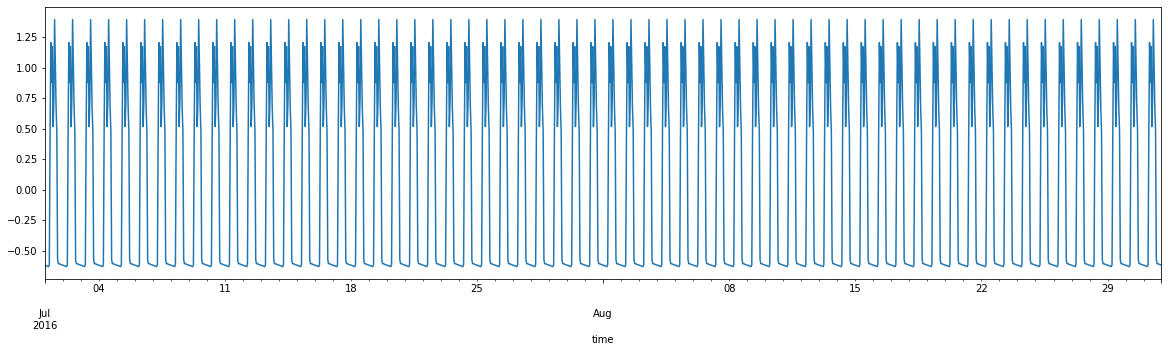


Decompostion for device: device_2
Observed


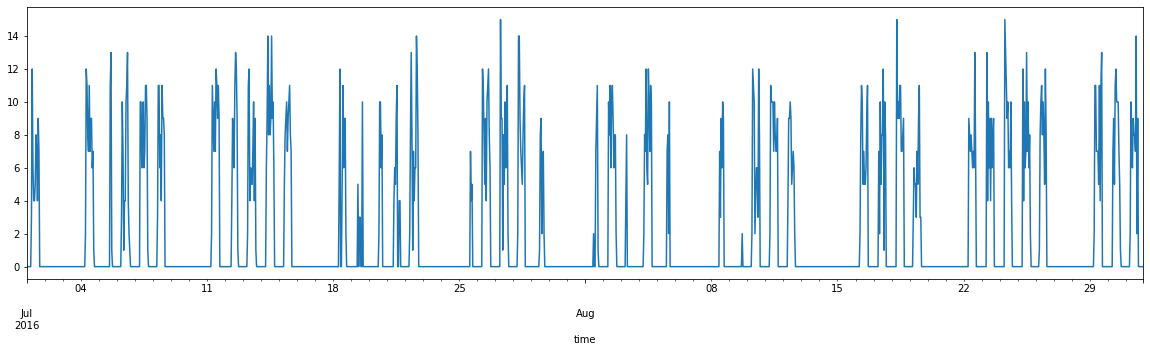

Trend


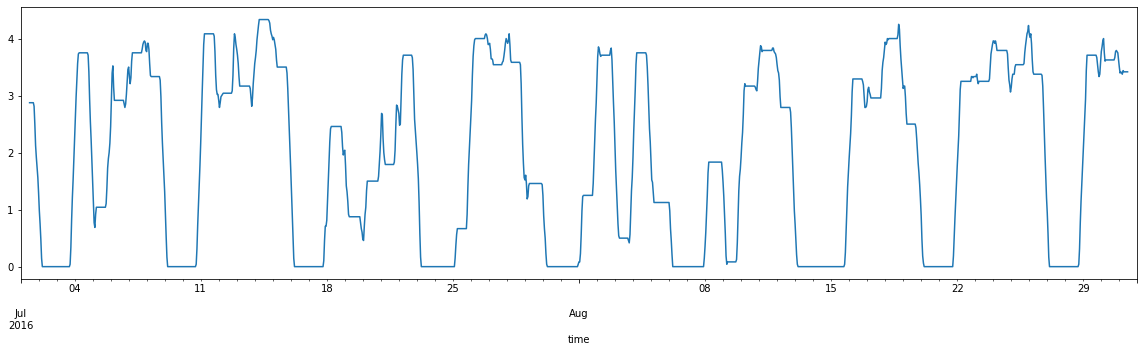

Seasonality


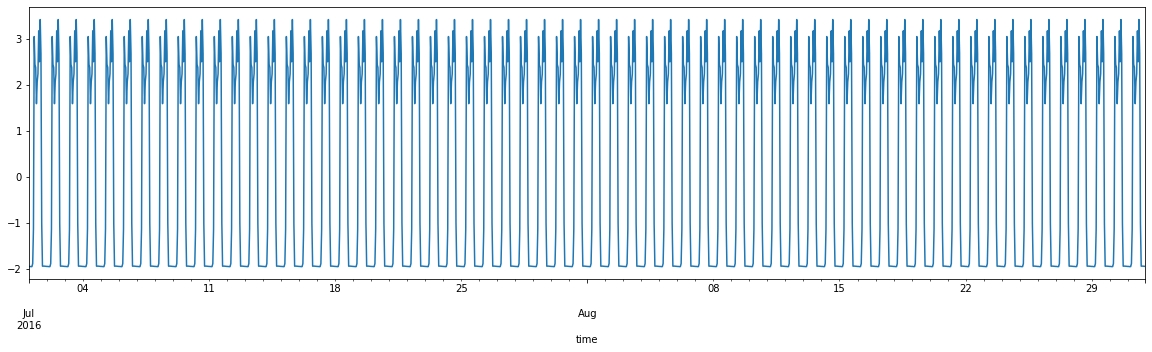


Decompostion for device: device_3
Observed


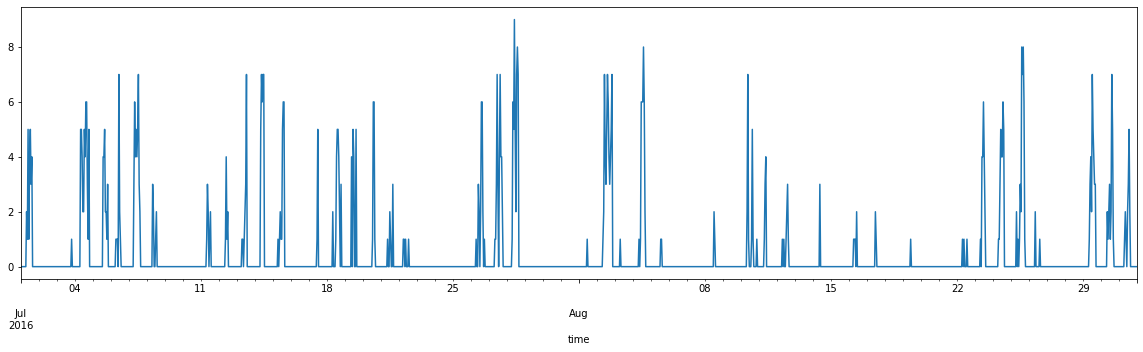

Trend


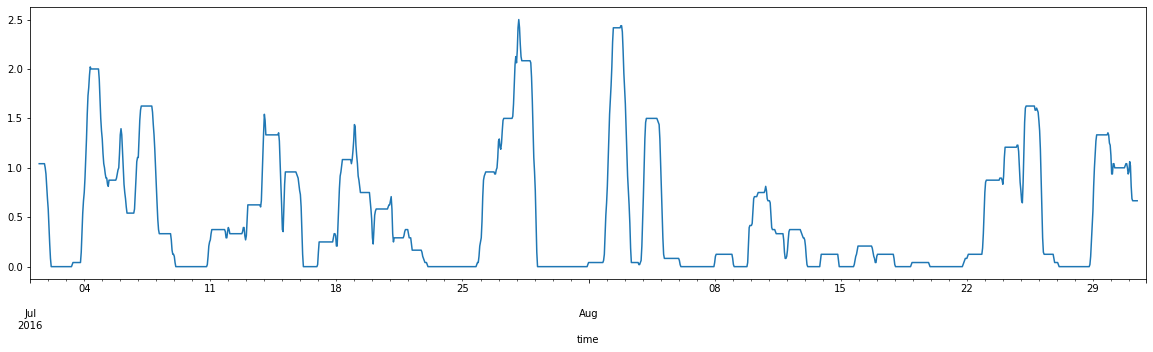

Seasonality


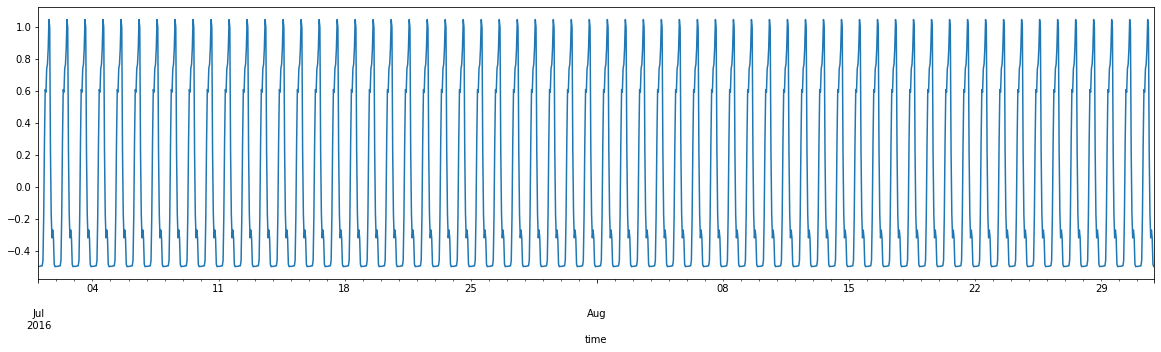


Decompostion for device: device_4
Observed


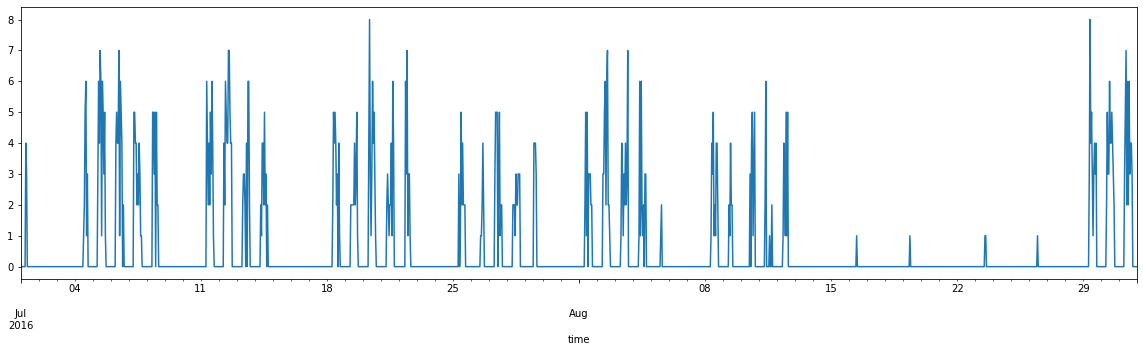

Trend


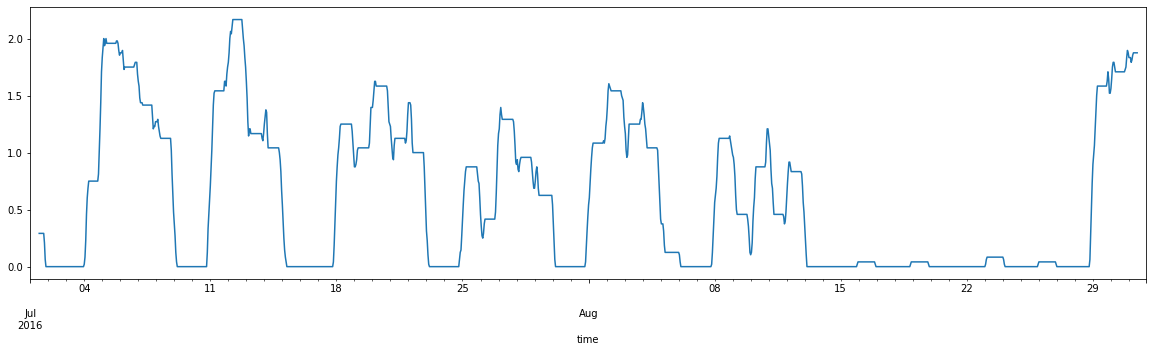

Seasonality


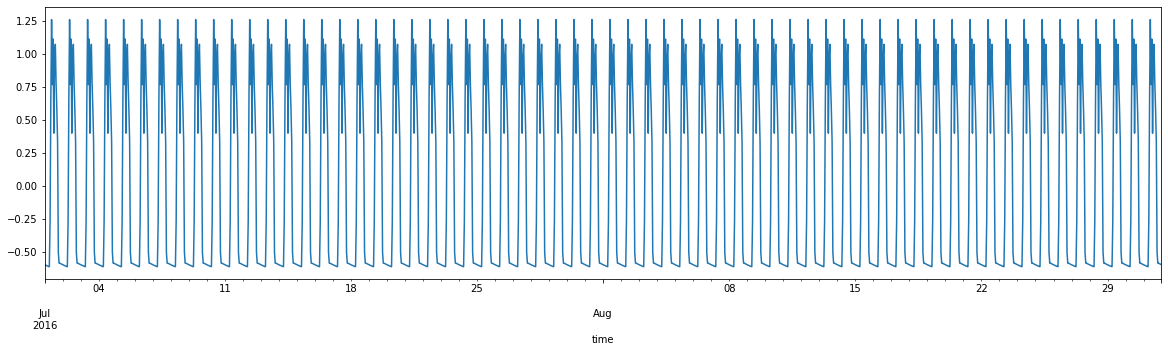


Decompostion for device: device_5
Observed


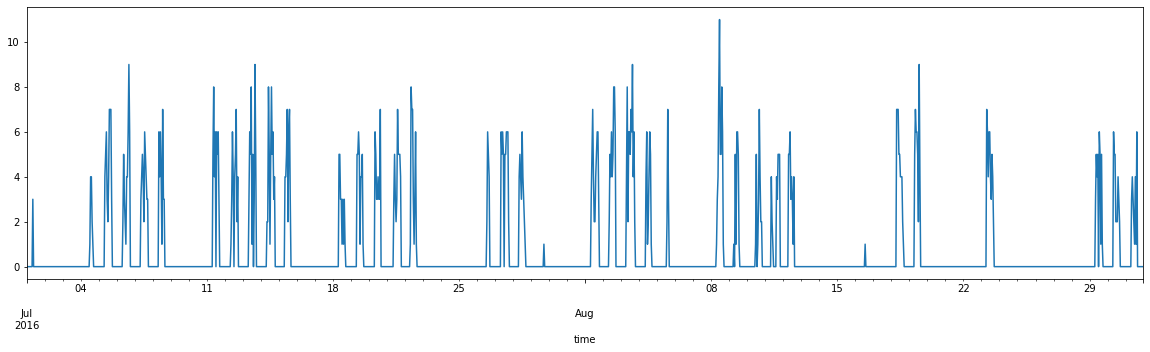

Trend


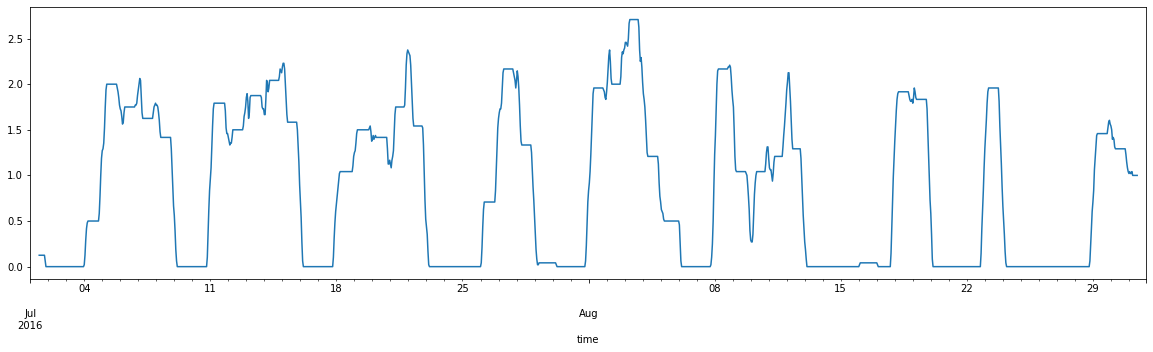

Seasonality


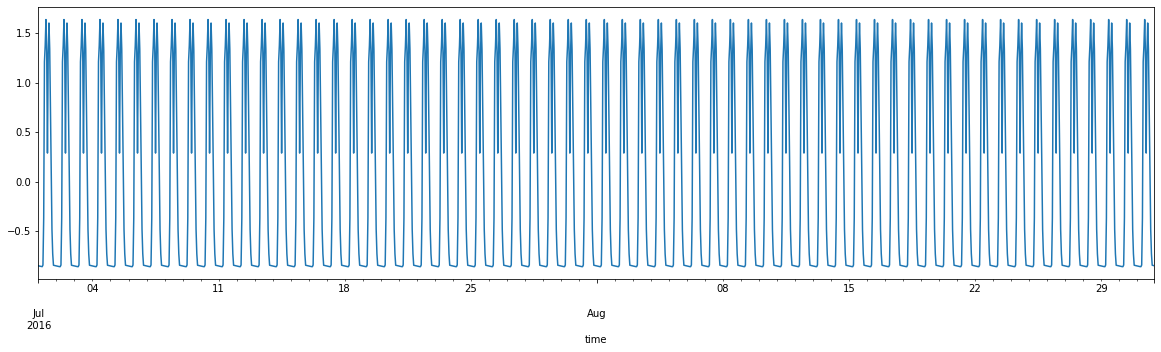


Decompostion for device: device_6
Observed


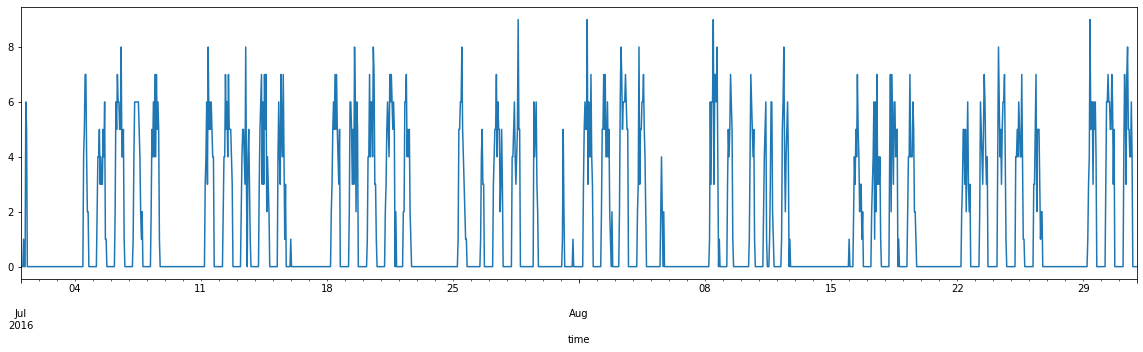

Trend


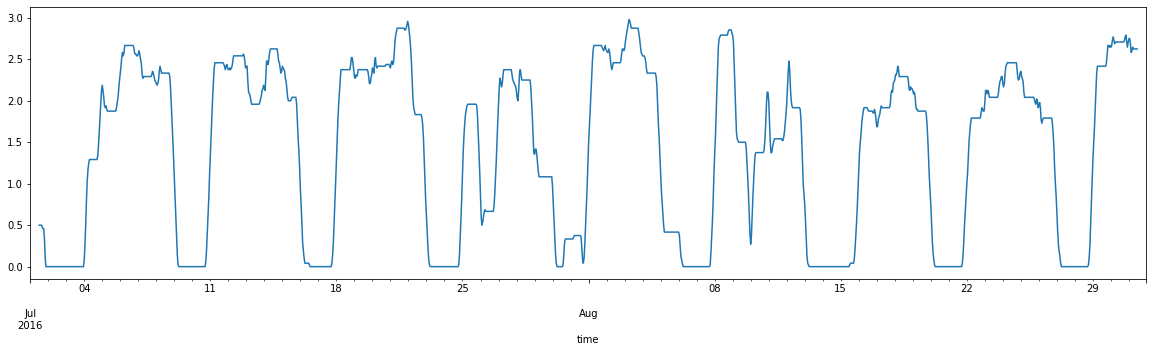

Seasonality


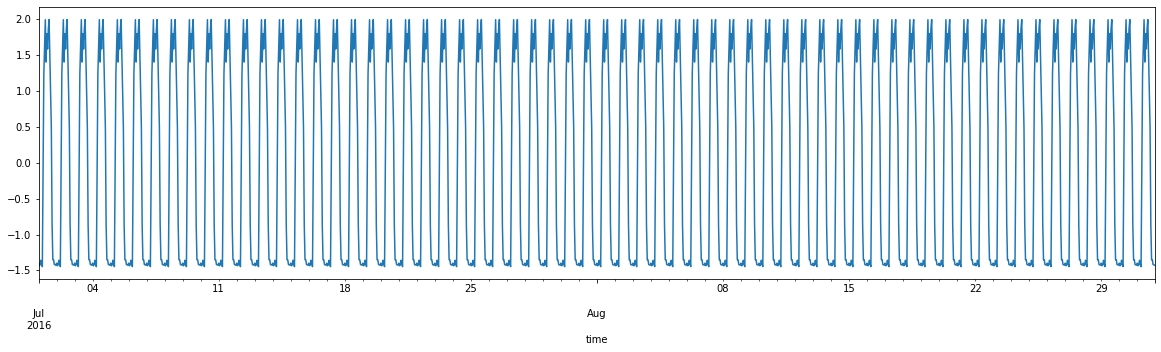


Decompostion for device: device_7
Observed


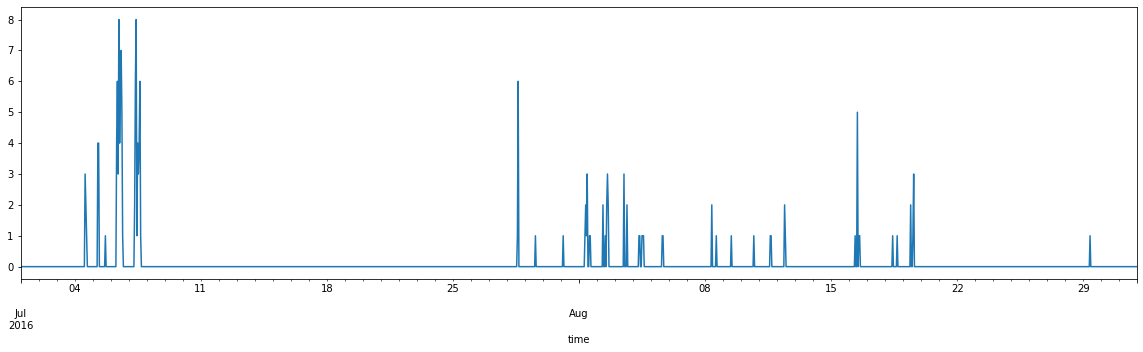

Trend


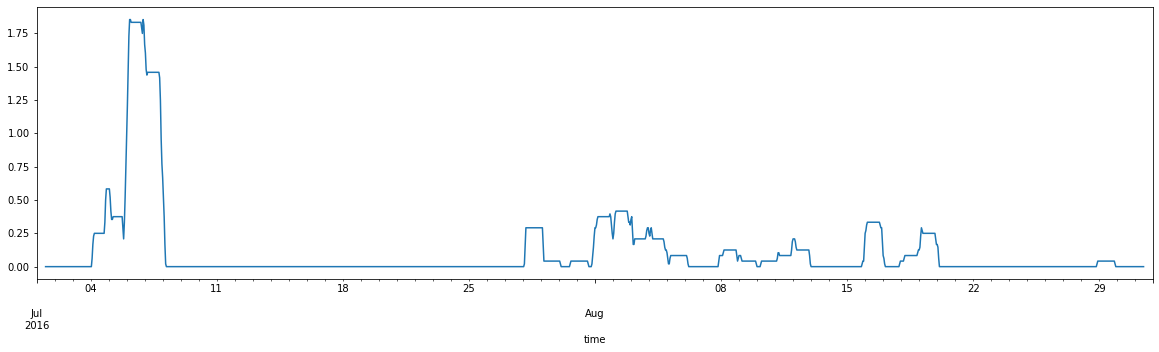

Seasonality


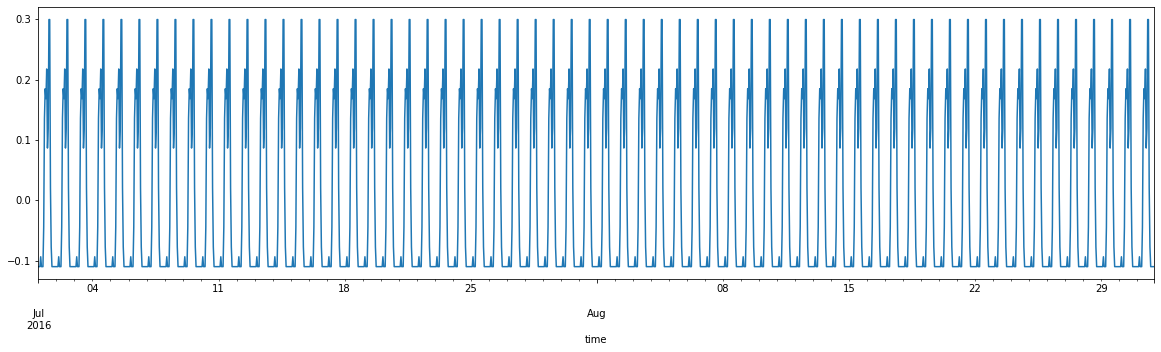

In [17]:
for dev in df_dict.keys():
    
    print(f"Decompostion for device: {dev}")
    
    dev_df = df_final[df_final["device"] == dev].set_index(['time'])[['device_activated']]
    dev_df.sort_index(inplace=True)
    res = sm.tsa.seasonal_decompose(dev_df, model='additive')
    
    print("Observed")
    plt.figure(figsize=(20, 5))
    res.observed.plot()
    plt.show()

    print("Trend")
    plt.figure(figsize=(20,5))
    res.trend.plot()
    plt.show()

    print("Seasonality")
    plt.figure(figsize=(20,5))
    res.seasonal.plot()
    plt.show()
    
    print()
          

### **Features**

In [18]:
df_final

time    device  device_activated
0    2016-07-01 04:00:00  device_6                 1
1    2016-07-01 06:00:00  device_2                 3
2    2016-07-01 07:00:00  device_2                12
3    2016-07-01 07:00:00  device_4                 4
4    2016-07-01 07:00:00  device_6                 6
...                  ...       ...               ...
1417 2016-08-17 03:00:00  device_7                 0
1418 2016-07-13 16:00:00  device_7                 0
1419 2016-08-25 08:00:00  device_7                 0
1420 2016-08-06 20:00:00  device_7                 0
1421 2016-08-17 09:00:00  device_7                 0

[10416 rows x 3 columns]

In [19]:
df_final["time"] = pd.to_datetime(df_final["time"])

In [20]:
df_final

time    device  device_activated
0    2016-07-01 04:00:00  device_6                 1
1    2016-07-01 06:00:00  device_2                 3
2    2016-07-01 07:00:00  device_2                12
3    2016-07-01 07:00:00  device_4                 4
4    2016-07-01 07:00:00  device_6                 6
...                  ...       ...               ...
1417 2016-08-17 03:00:00  device_7                 0
1418 2016-07-13 16:00:00  device_7                 0
1419 2016-08-25 08:00:00  device_7                 0
1420 2016-08-06 20:00:00  device_7                 0
1421 2016-08-17 09:00:00  device_7                 0

[10416 rows x 3 columns]

From looking at the problem, of identifying what rooms are busy, the most obvious feature that comes to mind is the hour of the day. I have no idea if its a store, an office or a hospital, but I image that the hour will be very important to capture phenomena at a lower level of granularity

In [21]:
df_final["hour"] = df_final['time'].dt.hour

In [22]:
df_final

time    device  device_activated  hour
0    2016-07-01 04:00:00  device_6                 1     4
1    2016-07-01 06:00:00  device_2                 3     6
2    2016-07-01 07:00:00  device_2                12     7
3    2016-07-01 07:00:00  device_4                 4     7
4    2016-07-01 07:00:00  device_6                 6     7
...                  ...       ...               ...   ...
1417 2016-08-17 03:00:00  device_7                 0     3
1418 2016-07-13 16:00:00  device_7                 0    16
1419 2016-08-25 08:00:00  device_7                 0     8
1420 2016-08-06 20:00:00  device_7                 0    20
1421 2016-08-17 09:00:00  device_7                 0     9

[10416 rows x 4 columns]

Another feature that could be important is to capture patterns at a very high level of aggregation, at the day of the week or `dow`...

In [23]:
df_final["dow"] = df_final['time'].dt.weekday

If this building is an office, a feature indicating if its weekend or not could be extremely valuable...

In [24]:
df_final["is_weekend"] = df_final['time'].dt.day_name().isin(['Saturday', 'Sunday'])

Also, could be usefull to add temporal patterns dividing the hours into bins...

In [25]:
b = [0,4,8,12,16,20,24]
l = ['late_night', 'early_morning','morning','noon', 'eve','night']
df_final['session'] = pd.cut(df_final['hour'], bins=b, labels=l, include_lowest=True)

In [26]:
df_final

time    device  device_activated  hour  dow  is_weekend  \
0    2016-07-01 04:00:00  device_6                 1     4    4       False   
1    2016-07-01 06:00:00  device_2                 3     6    4       False   
2    2016-07-01 07:00:00  device_2                12     7    4       False   
3    2016-07-01 07:00:00  device_4                 4     7    4       False   
4    2016-07-01 07:00:00  device_6                 6     7    4       False   
...                  ...       ...               ...   ...  ...         ...   
1417 2016-08-17 03:00:00  device_7                 0     3    2       False   
1418 2016-07-13 16:00:00  device_7                 0    16    2       False   
1419 2016-08-25 08:00:00  device_7                 0     8    3       False   
1420 2016-08-06 20:00:00  device_7                 0    20    5        True   
1421 2016-08-17 09:00:00  device_7                 0     9    2       False   

            session  
0        late_night  
1     early_morning  
2     early_morning  
3     early_morning  
4     early_morning  
...             ...  
1417     late_night  
1418           noon  
1419  early_morning  
1420            eve  
1421        morning  

[10416 rows x 7 columns]

In [27]:
df_final["woy"] = df_final['time'].dt.isocalendar().week

In [28]:
df_final

time    device  device_activated  hour  dow  is_weekend  \
0    2016-07-01 04:00:00  device_6                 1     4    4       False   
1    2016-07-01 06:00:00  device_2                 3     6    4       False   
2    2016-07-01 07:00:00  device_2                12     7    4       False   
3    2016-07-01 07:00:00  device_4                 4     7    4       False   
4    2016-07-01 07:00:00  device_6                 6     7    4       False   
...                  ...       ...               ...   ...  ...         ...   
1417 2016-08-17 03:00:00  device_7                 0     3    2       False   
1418 2016-07-13 16:00:00  device_7                 0    16    2       False   
1419 2016-08-25 08:00:00  device_7                 0     8    3       False   
1420 2016-08-06 20:00:00  device_7                 0    20    5        True   
1421 2016-08-17 09:00:00  device_7                 0     9    2       False   

            session  woy  
0        late_night   26  
1     early_morning   26  
2     early_morning   26  
3     early_morning   26  
4     early_morning   26  
...             ...  ...  
1417     late_night   33  
1418           noon   28  
1419  early_morning   34  
1420            eve   31  
1421        morning   33  

[10416 rows x 8 columns]

The target should be a value of 1 if we predict that the room will be occupied and 0 if you predict that it will not be occupied for each of the following 24 hours. 

In [29]:
df_final["label"] = np.where(df_final["device_activated"] > 0, 1, 0)

In [30]:
df_final.iloc[1263]

time                2016-08-09 12:00:00
device                         device_6
device_activated                      5
hour                                 12
dow                                   1
is_weekend                        False
session                         morning
woy                                  32
label                                 1
Name: 1263, dtype: object

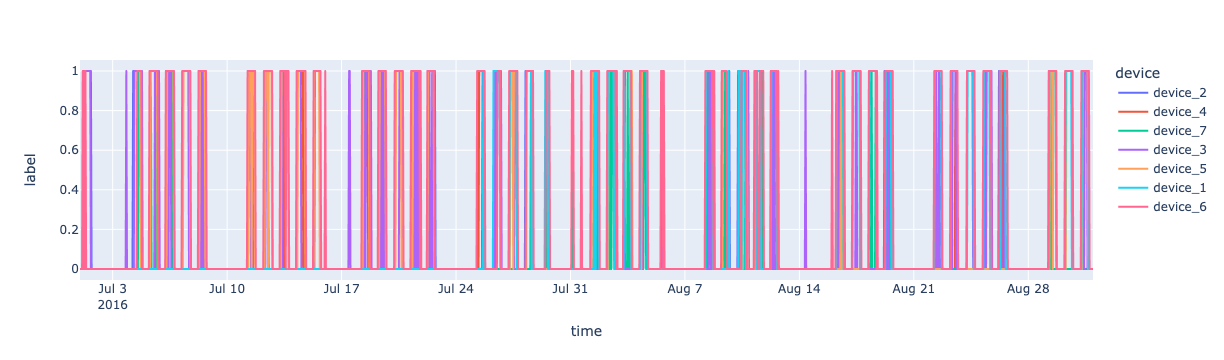

In [31]:
fig = px.line(df_final.sort_values(["time"]), x='time', y="label", color="device",
              line_group="device")
fig.show()

In [32]:
df_final

time    device  device_activated  hour  dow  is_weekend  \
0    2016-07-01 04:00:00  device_6                 1     4    4       False   
1    2016-07-01 06:00:00  device_2                 3     6    4       False   
2    2016-07-01 07:00:00  device_2                12     7    4       False   
3    2016-07-01 07:00:00  device_4                 4     7    4       False   
4    2016-07-01 07:00:00  device_6                 6     7    4       False   
...                  ...       ...               ...   ...  ...         ...   
1417 2016-08-17 03:00:00  device_7                 0     3    2       False   
1418 2016-07-13 16:00:00  device_7                 0    16    2       False   
1419 2016-08-25 08:00:00  device_7                 0     8    3       False   
1420 2016-08-06 20:00:00  device_7                 0    20    5        True   
1421 2016-08-17 09:00:00  device_7                 0     9    2       False   

            session  woy  label  
0        late_night   26      1  
1     early_morning   26      1  
2     early_morning   26      1  
3     early_morning   26      1  
4     early_morning   26      1  
...             ...  ...    ...  
1417     late_night   33      0  
1418           noon   28      0  
1419  early_morning   34      0  
1420            eve   31      0  
1421        morning   33      0  

[10416 rows x 9 columns]

In [33]:
df_final_ohe = pd.get_dummies(df_final[["device", "session"]])

In [34]:
df_final_ohe

device_device_1  device_device_2  device_device_3  device_device_4  \
0                   0                0                0                0   
1                   0                1                0                0   
2                   0                1                0                0   
3                   0                0                0                1   
4                   0                0                0                0   
...               ...              ...              ...              ...   
1417                0                0                0                0   
1418                0                0                0                0   
1419                0                0                0                0   
1420                0                0                0                0   
1421                0                0                0                0   

      device_device_5  device_device_6  device_device_7  session_late_night  \
0                   0                1                0                   1   
1                   0                0                0                   0   
2                   0                0                0                   0   
3                   0                0                0                   0   
4                   0                1                0                   0   
...               ...              ...              ...                 ...   
1417                0                0                1                   1   
1418                0                0                1                   0   
1419                0                0                1                   0   
1420                0                0                1                   0   
1421                0                0                1                   0   

      session_early_morning  session_morning  session_noon  session_eve  \
0                         0                0             0            0   
1                         1                0             0            0   
2                         1                0             0            0   
3                         1                0             0            0   
4                         1                0             0            0   
...                     ...              ...           ...          ...   
1417                      0                0             0            0   
1418                      0                0             1            0   
1419                      1                0             0            0   
1420                      0                0             0            1   
1421                      0                1             0            0   

      session_night  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
1417              0  
1418              0  
1419              0  
1420              0  
1421              0  

[10416 rows x 13 columns]

In [35]:
data = pd.concat([df_final.drop(columns=["device", "device_activated", "session"]), df_final_ohe], axis = 1)

In [36]:
data = data.reset_index(drop=True)

In [37]:
data

time  hour  dow  is_weekend  woy  label  device_device_1  \
0     2016-07-01 04:00:00     4    4       False   26      1                0   
1     2016-07-01 06:00:00     6    4       False   26      1                0   
2     2016-07-01 07:00:00     7    4       False   26      1                0   
3     2016-07-01 07:00:00     7    4       False   26      1                0   
4     2016-07-01 07:00:00     7    4       False   26      1                0   
...                   ...   ...  ...         ...  ...    ...              ...   
10411 2016-08-17 03:00:00     3    2       False   33      0                0   
10412 2016-07-13 16:00:00    16    2       False   28      0                0   
10413 2016-08-25 08:00:00     8    3       False   34      0                0   
10414 2016-08-06 20:00:00    20    5        True   31      0                0   
10415 2016-08-17 09:00:00     9    2       False   33      0                0   

       device_device_2  device_device_3  device_device_4  device_device_5  \
0                    0                0                0                0   
1                    1                0                0                0   
2                    1                0                0                0   
3                    0                0                1                0   
4                    0                0                0                0   
...                ...              ...              ...              ...   
10411                0                0                0                0   
10412                0                0                0                0   
10413                0                0                0                0   
10414                0                0                0                0   
10415                0                0                0                0   

       device_device_6  device_device_7  session_late_night  \
0                    1                0                   1   
1                    0                0                   0   
2                    0                0                   0   
3                    0                0                   0   
4                    1                0                   0   
...                ...              ...                 ...   
10411                0                1                   1   
10412                0                1                   0   
10413                0                1                   0   
10414                0                1                   0   
10415                0                1                   0   

       session_early_morning  session_morning  session_noon  session_eve  \
0                          0                0             0            0   
1                          1                0             0            0   
2                          1                0             0            0   
3                          1                0             0            0   
4                          1                0             0            0   
...                      ...              ...           ...          ...   
10411                      0                0             0            0   
10412                      0                0             1            0   
10413                      1                0             0            0   
10414                      0                0             0            1   
10415                      0                1             0            0   

       session_night  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
10411              0  
10412              0  
10413              0  
10414              0  
10415              0  

[10416 rows x 19 columns]

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10416 entries, 0 to 10415
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   time                   10416 non-null  datetime64[ns]
 1   hour                   10416 non-null  int64         
 2   dow                    10416 non-null  int64         
 3   is_weekend             10416 non-null  bool          
 4   woy                    10416 non-null  UInt32        
 5   label                  10416 non-null  int64         
 6   device_device_1        10416 non-null  uint8         
 7   device_device_2        10416 non-null  uint8         
 8   device_device_3        10416 non-null  uint8         
 9   device_device_4        10416 non-null  uint8         
 10  device_device_5        10416 non-null  uint8         
 11  device_device_6        10416 non-null  uint8         
 12  device_device_7        10416 non-null  uint8         
 13  s

Event that we are dealing with a classification problem, we need to take into account the temporal pattern of the timeseries. 

Using just a random split can lead to problems when using lags, even when using just temporal features. 

To solve that, I am using 1 month for training (from 2016-07-01 to 2016-08-01) and using a gap of 7 days between train and test (from 2016-08-07 to max `time` available.

In [39]:
def temporal_train_test_split(df, train_end='2016-08-01', test_start='2016-08-07'):
    df["time"] = pd.to_datetime(df["time"])
    
    df_ord = df.sort_values(by=["time"])
    
    _df = df_ord.set_index('time')
    
    df_train = _df[:train_end].reset_index()
    df_test = _df[test_start:].reset_index()
    
    
    return (df_train.drop(columns=["time", "label"]), df_test.drop(columns=["time", "label"]),
            df_train[["label"]], df_test[["label"]])

Looking at the new feature that I created there is 1 binary feature `is_weekend`, 13 dummy features for `device` and `session` and 3 numeric features (temporal features - `hour`, `dow` and `woy`).

For the numerical features it's important to standardize the data in order to have interpretable coefficients.


If we don't standardize the numerical features our coefficients will represent the amount by which dependent variable changes if we change independent variable by 1 unit keeping other independent variables constant.

- Unstandardized coefficients are great for interpreting the relationship between an independent variable X and an outcome Y. However, they are not useful for comparing the effect of an independent variable with another one in the model.

Problem? The interpretation of standardized regression coefficients is non-intuitive compared to their unstandardized versions:

- A change of 1 standard deviation in X is associated with a change of β standard deviations of Y.

In [40]:
def train_model(df, std_cols, dummy_cols):
    
    df_aux = df[std_cols + dummy_cols + ["label", "time"]]
    
    X_train, X_test, y_train, y_test = temporal_train_test_split(df_aux)
    
    scaler = StandardScaler()

    X_train[std_cols] = scaler.fit_transform(X_train[std_cols])
    X_test[std_cols] = scaler.transform(X_test[std_cols])
    
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    
    predictions = lr.predict(X_test)
    
    print(classification_report(predictions, y_test))
    
    coef=dict(zip(X_train.columns.tolist(), lr.coef_.tolist()[0]))
    
    print(pd.DataFrame.from_dict(data=coef, orient="index", columns=["standardized_model_coefs"]))
    pd.DataFrame.from_dict(data=coef, orient="index", columns=["standardized_model_coefs"]).plot(kind="bar")
    plt.show()
    
    explainer = shap.LinearExplainer(lr, X_train, feature_perturbation="independent")
    shap_values = explainer(X_test)
    
    shap_values1 = shap_values.values.astype(np.float)
    shap.summary_plot(shap_values1, X_test)
    
    return X_test, y_test, lr, explainer

#### **Model 1** - using `hour`

              precision    recall  f1-score   support

           0       1.00      0.82      0.90      4200
           1       0.00      0.00      0.00         0

    accuracy                           0.82      4200
   macro avg       0.50      0.41      0.45      4200
weighted avg       1.00      0.82      0.90      4200

                 standardized_model_coefs
hour                             0.119943
device_device_1                 -1.207900
device_device_2                  0.608855
device_device_3                  0.088801
device_device_4                  0.474063
device_device_5                  0.421887
device_device_6                  0.957744
device_device_7                 -1.343575


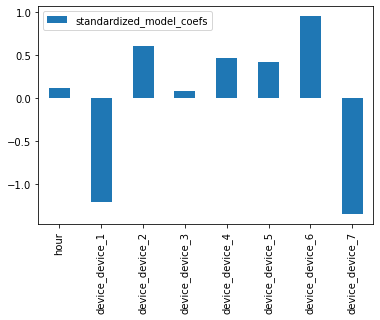

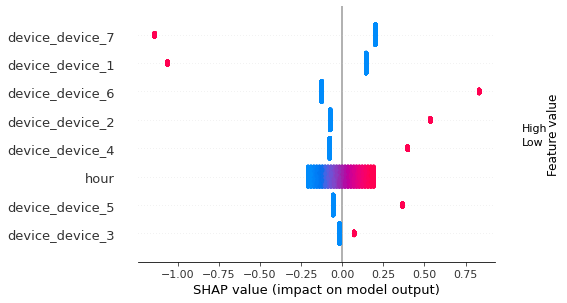

In [41]:
X_test_1, y_test_1, model_1, explainer_1 = train_model(data, std_cols=["hour"], dummy_cols=data.filter(like='device_').columns.tolist())

#### **Model 2** - using `hour` + `dow`

              precision    recall  f1-score   support

           0       0.97      0.82      0.89      4044
           1       0.06      0.28      0.09       156

    accuracy                           0.80      4200
   macro avg       0.51      0.55      0.49      4200
weighted avg       0.93      0.80      0.86      4200

                 standardized_model_coefs
hour                             0.131139
dow                             -0.748711
device_device_1                 -1.279220
device_device_2                  0.645970
device_device_3                  0.078904
device_device_4                  0.497584
device_device_5                  0.440411
device_device_6                  1.034344
device_device_7                 -1.418003


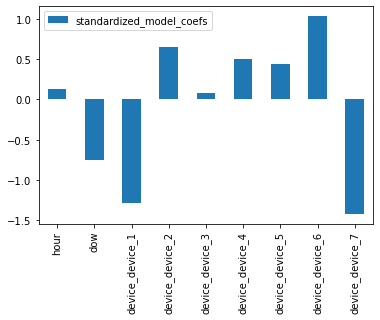

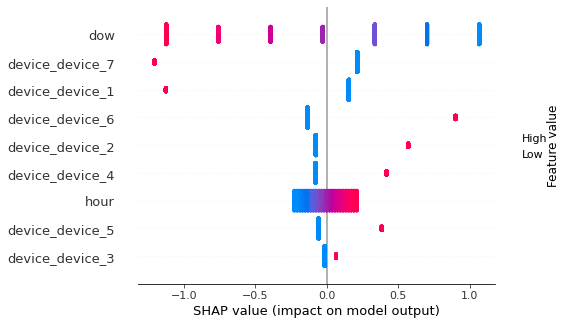

In [42]:
X_test_2, y_test_2, model_2, explainer_2 = train_model(data, std_cols=["hour", "dow"], dummy_cols=data.filter(like='device_').columns.tolist())

#### **Model 3** - using `hour` + `dow` + `is_weekend`

              precision    recall  f1-score   support

           0       0.98      0.81      0.89      4108
           1       0.01      0.11      0.02        92

    accuracy                           0.80      4200
   macro avg       0.49      0.46      0.46      4200
weighted avg       0.95      0.80      0.87      4200

                 standardized_model_coefs
hour                             0.137539
dow                             -0.073711
is_weekend                      -3.846848
device_device_1                 -1.294699
device_device_2                  0.653592
device_device_3                  0.067619
device_device_4                  0.498050
device_device_5                  0.438640
device_device_6                  1.073362
device_device_7                 -1.433166


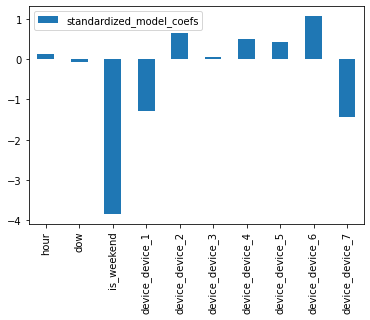

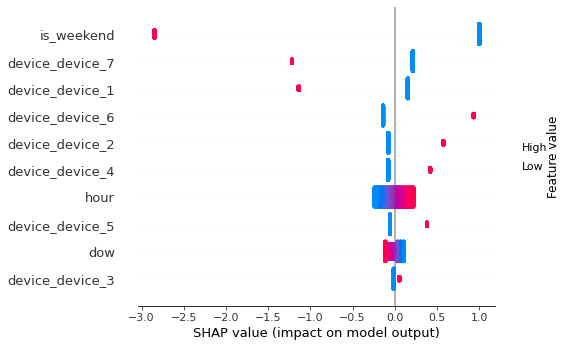

In [43]:
X_test_3, y_test_3, model_3, explainer_3 = train_model(data, std_cols=["hour", "dow"], dummy_cols=["is_weekend"]+
                                                                                                        data.filter(like='device_').columns.tolist())

#### **Model 4** - using `hour` + `dow` + `is_weekend` + `session`

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3408
           1       0.62      0.61      0.62       792

    accuracy                           0.86      4200
   macro avg       0.77      0.76      0.76      4200
weighted avg       0.86      0.86      0.86      4200

                       standardized_model_coefs
hour                                   0.199052
dow                                   -0.125620
is_weekend                            -4.558403
device_device_1                       -1.765532
device_device_2                        0.899340
device_device_3                       -0.048485
device_device_4                        0.632275
device_device_5                        0.533123
device_device_6                        1.666904
device_device_7                       -1.918078
session_late_night                    -2.547454
session_early_morning                  0.955783
session_morning                        2.551766
s

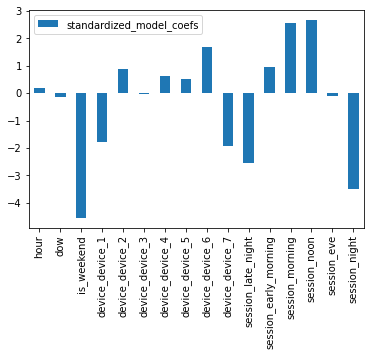

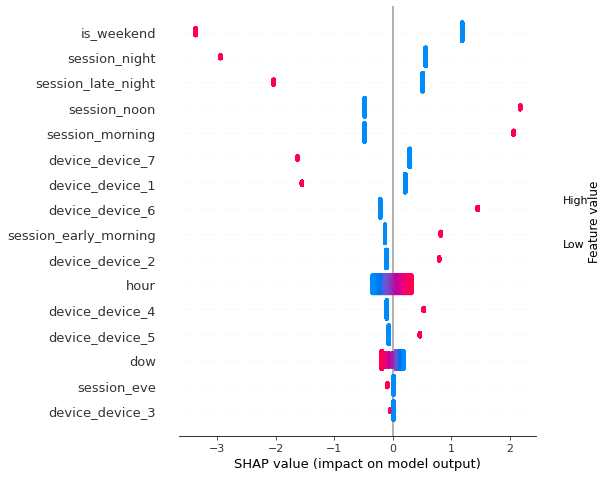

In [44]:
X_test_4, y_test_4, model_4, explainer_4 = train_model(data, std_cols=["hour", "dow"], dummy_cols=["is_weekend"]+
                                                                                            data.filter(like='device_').columns.tolist() +
                                                                                            data.filter(like='session_').columns.tolist())

Very interesting.

- The `is_weekend` is highly discriminative, the values contributing to a positive/negative label are in the extreme opposites. The same for `session_late_night`, `session_morning`, etc.

- `hour`, `dow` and `woy` are very different as they look to be more progressive, a higher value contributes negatively for the predictions and low values (maybe because of the business hours assumption)...

- Another thing that I found very interesting in this SHAP plot is that we have devices very close to each other (indicating a similar stength?) for the model: `device_6` and `device_7`, `device_1` and `device_3` and `device_5` and `device_4`,

Lets see in the same plot form above:

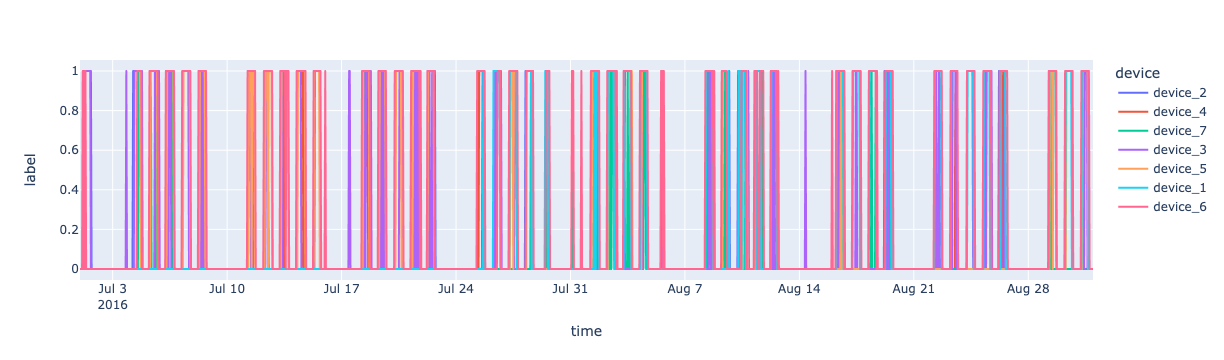

In [45]:
fig = px.line(df_final.sort_values(["time"]), x='time', y="label", color="device",
              line_group="device")
fig.show()

- There's some overlap but not perfect 6 and 7 as for the others - looks like that for some points were set to 0 and shifted in time....
- device_4 and device_5 are very very similar

Classification Stats for Device: device_1

              precision    recall  f1-score   support

           0       1.00      0.75      0.86       600
           1       0.00      0.00      0.00         0

    accuracy                           0.75       600
   macro avg       0.50      0.38      0.43       600
weighted avg       1.00      0.75      0.86       600



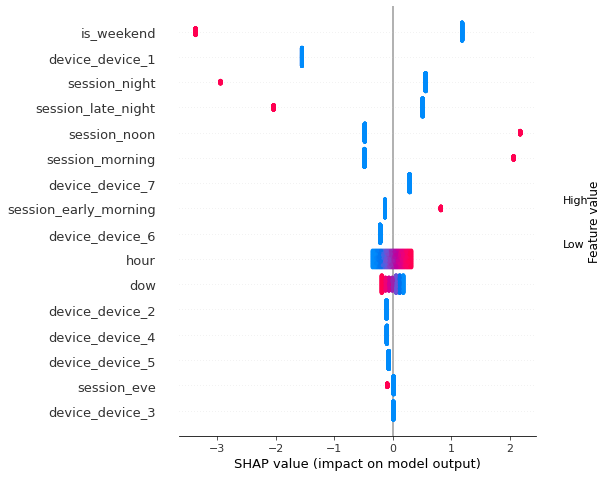


Classification Stats for Device: device_2

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       456
           1       0.74      0.85      0.79       144

    accuracy                           0.89       600
   macro avg       0.84      0.88      0.86       600
weighted avg       0.90      0.89      0.89       600



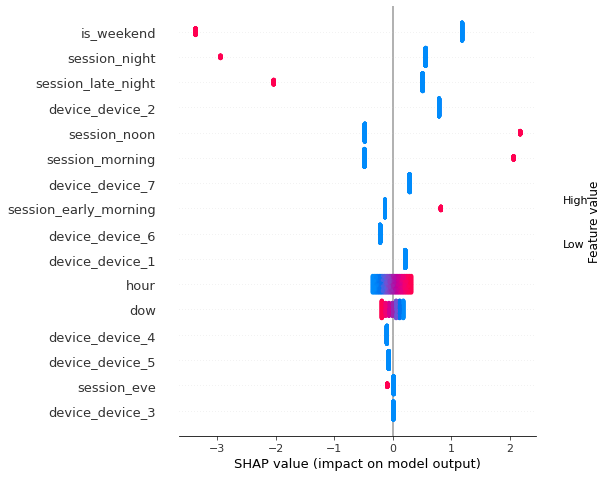


Classification Stats for Device: device_3

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       456
           1       0.74      0.41      0.53       144

    accuracy                           0.82       600
   macro avg       0.79      0.68      0.71       600
weighted avg       0.81      0.82      0.80       600



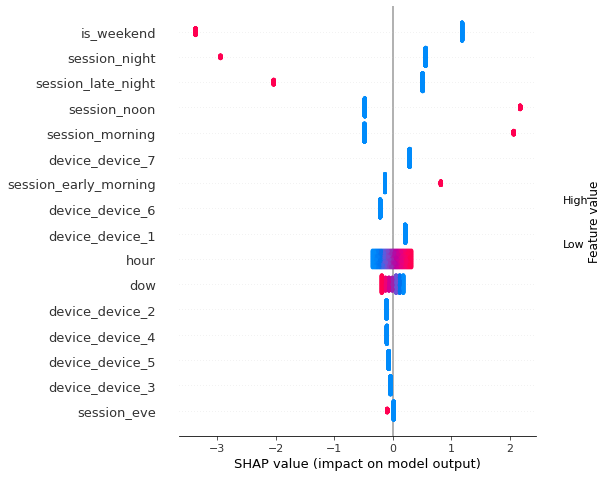


Classification Stats for Device: device_4

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       456
           1       0.77      0.37      0.50       144

    accuracy                           0.82       600
   macro avg       0.80      0.67      0.69       600
weighted avg       0.81      0.82      0.80       600



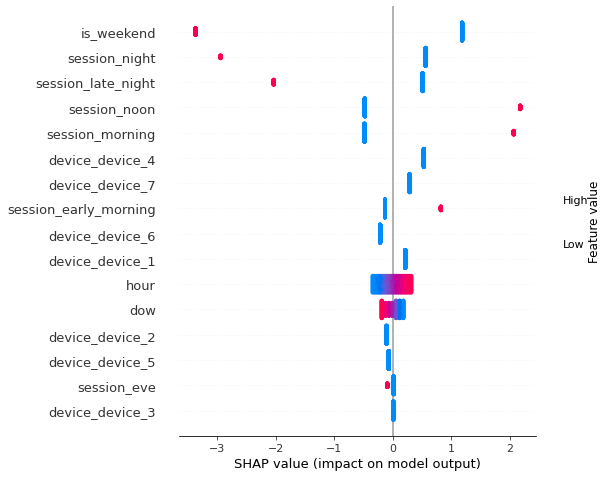


Classification Stats for Device: device_5

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       456
           1       0.76      0.51      0.61       144

    accuracy                           0.84       600
   macro avg       0.81      0.73      0.76       600
weighted avg       0.84      0.84      0.83       600



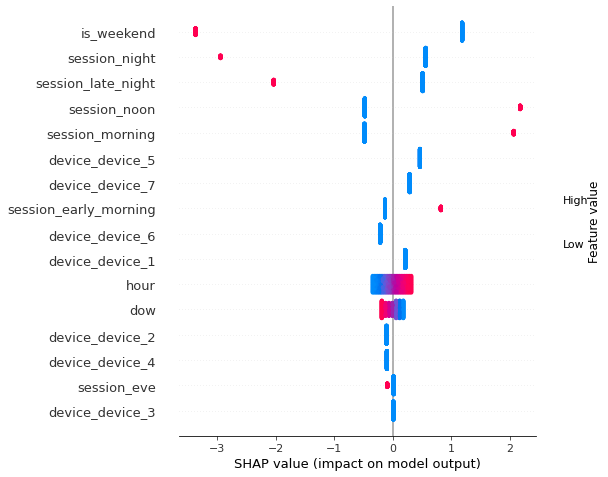


Classification Stats for Device: device_6

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       384
           1       0.89      0.81      0.85       216

    accuracy                           0.90       600
   macro avg       0.89      0.88      0.88       600
weighted avg       0.89      0.90      0.89       600



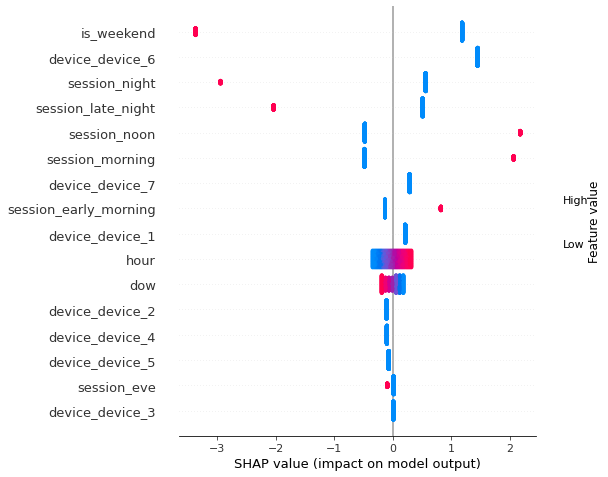


Classification Stats for Device: device_7

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       600
           1       0.00      0.00      0.00         0

    accuracy                           0.97       600
   macro avg       0.50      0.48      0.49       600
weighted avg       1.00      0.97      0.98       600



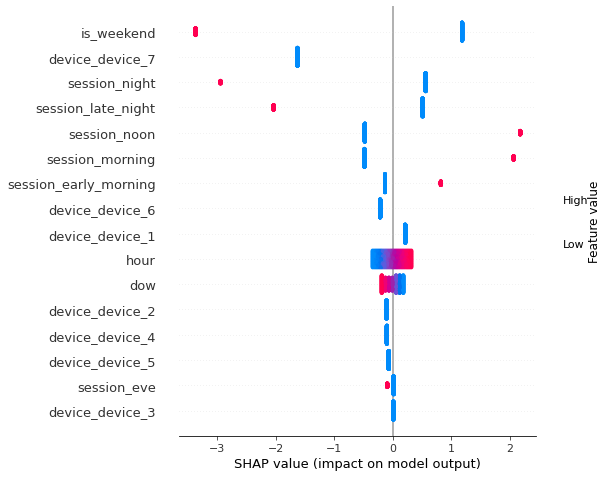

In [46]:
for dev in df_dict.keys():
    
    print(f"Classification Stats for Device: {dev}\n")
    
    X_test_dev = X_test_4[X_test_4[f"device_{dev}"] == 1]
    y_test_dev = y_test_4.loc[X_test_dev.index]
                    
    pred = model_4.predict(X_test_dev)

    print(classification_report(pred, y_test_dev))
    
    shap_values = explainer_4(X_test_dev)
    shap_values1 = shap_values.values.astype(np.float)
    
    shap.summary_plot(shap_values1, X_test_dev)
    
    print()

In [47]:
df_final

time    device  device_activated  hour  dow  is_weekend  \
0    2016-07-01 04:00:00  device_6                 1     4    4       False   
1    2016-07-01 06:00:00  device_2                 3     6    4       False   
2    2016-07-01 07:00:00  device_2                12     7    4       False   
3    2016-07-01 07:00:00  device_4                 4     7    4       False   
4    2016-07-01 07:00:00  device_6                 6     7    4       False   
...                  ...       ...               ...   ...  ...         ...   
1417 2016-08-17 03:00:00  device_7                 0     3    2       False   
1418 2016-07-13 16:00:00  device_7                 0    16    2       False   
1419 2016-08-25 08:00:00  device_7                 0     8    3       False   
1420 2016-08-06 20:00:00  device_7                 0    20    5        True   
1421 2016-08-17 09:00:00  device_7                 0     9    2       False   

            session  woy  label  
0        late_night   26      1  
1     early_morning   26      1  
2     early_morning   26      1  
3     early_morning   26      1  
4     early_morning   26      1  
...             ...  ...    ...  
1417     late_night   33      0  
1418           noon   28      0  
1419  early_morning   34      0  
1420            eve   31      0  
1421        morning   33      0  

[10416 rows x 9 columns]

Like I said before, this problem screams for lag features at different granularities. This is an easy way to improve the model performance (lags were the 1st features I thought of), but the question is at prediction time.

If we want to predict for **any** given time interval, if we try to predict for a day in 3 months time. these features will be outdated cause the lags will be from 3 months ago.  If on other hand, we always try to predict the **next** 24 hours we will be fine, cause we dont have any lags lower than 24 hours. 

In [48]:
def compute_lag_features(df):
    
    lag_list = [24, 48, 72, 96, 120, 168]
    
    for lag in lag_list:

        df = df.sort_values(by=['time'])
        df[f"lag_{lag}"] = df["label"].shift(lag)

    return df

In [49]:
df_lag = df_final.groupby(["device"]).apply(lambda x: compute_lag_features(x)).drop(columns=["device"])

In [50]:
df_lag = df_lag.reset_index()

In [51]:
df_lag = df_lag.drop(columns=["level_1"])

In [52]:
df_lag

device                time  device_activated  hour  dow  is_weekend  \
0      device_1 2016-07-01 00:00:00                 0     0    4       False   
1      device_1 2016-07-01 01:00:00                 0     1    4       False   
2      device_1 2016-07-01 02:00:00                 0     2    4       False   
3      device_1 2016-07-01 03:00:00                 0     3    4       False   
4      device_1 2016-07-01 04:00:00                 0     4    4       False   
...         ...                 ...               ...   ...  ...         ...   
10411  device_7 2016-08-31 19:00:00                 0    19    2       False   
10412  device_7 2016-08-31 20:00:00                 0    20    2       False   
10413  device_7 2016-08-31 21:00:00                 0    21    2       False   
10414  device_7 2016-08-31 22:00:00                 0    22    2       False   
10415  device_7 2016-08-31 23:00:00                 0    23    2       False   

          session  woy  label  lag_24  lag_48  lag_72  lag_96  lag_120  \
0      late_night   26      0     NaN     NaN     NaN     NaN      NaN   
1      late_night   26      0     NaN     NaN     NaN     NaN      NaN   
2      late_night   26      0     NaN     NaN     NaN     NaN      NaN   
3      late_night   26      0     NaN     NaN     NaN     NaN      NaN   
4      late_night   26      0     NaN     NaN     NaN     NaN      NaN   
...           ...  ...    ...     ...     ...     ...     ...      ...   
10411         eve   35      0     0.0     0.0     0.0     0.0      0.0   
10412         eve   35      0     0.0     0.0     0.0     0.0      0.0   
10413       night   35      0     0.0     0.0     0.0     0.0      0.0   
10414       night   35      0     0.0     0.0     0.0     0.0      0.0   
10415       night   35      0     0.0     0.0     0.0     0.0      0.0   

       lag_168  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
...        ...  
10411      0.0  
10412      0.0  
10413      0.0  
10414      0.0  
10415      0.0  

[10416 rows x 15 columns]

In [53]:
df_final_dvce = pd.get_dummies(df_lag[["device", "session"]])

In [54]:
data = pd.concat([df_lag, df_final_dvce], axis = 1)

In [55]:
data

device                time  device_activated  hour  dow  is_weekend  \
0      device_1 2016-07-01 00:00:00                 0     0    4       False   
1      device_1 2016-07-01 01:00:00                 0     1    4       False   
2      device_1 2016-07-01 02:00:00                 0     2    4       False   
3      device_1 2016-07-01 03:00:00                 0     3    4       False   
4      device_1 2016-07-01 04:00:00                 0     4    4       False   
...         ...                 ...               ...   ...  ...         ...   
10411  device_7 2016-08-31 19:00:00                 0    19    2       False   
10412  device_7 2016-08-31 20:00:00                 0    20    2       False   
10413  device_7 2016-08-31 21:00:00                 0    21    2       False   
10414  device_7 2016-08-31 22:00:00                 0    22    2       False   
10415  device_7 2016-08-31 23:00:00                 0    23    2       False   

          session  woy  label  lag_24  ...  device_device_4  device_device_5  \
0      late_night   26      0     NaN  ...                0                0   
1      late_night   26      0     NaN  ...                0                0   
2      late_night   26      0     NaN  ...                0                0   
3      late_night   26      0     NaN  ...                0                0   
4      late_night   26      0     NaN  ...                0                0   
...           ...  ...    ...     ...  ...              ...              ...   
10411         eve   35      0     0.0  ...                0                0   
10412         eve   35      0     0.0  ...                0                0   
10413       night   35      0     0.0  ...                0                0   
10414       night   35      0     0.0  ...                0                0   
10415       night   35      0     0.0  ...                0                0   

       device_device_6  device_device_7  session_late_night  \
0                    0                0                   1   
1                    0                0                   1   
2                    0                0                   1   
3                    0                0                   1   
4                    0                0                   1   
...                ...              ...                 ...   
10411                0                1                   0   
10412                0                1                   0   
10413                0                1                   0   
10414                0                1                   0   
10415                0                1                   0   

       session_early_morning  session_morning  session_noon  session_eve  \
0                          0                0             0            0   
1                          0                0             0            0   
2                          0                0             0            0   
3                          0                0             0            0   
4                          0                0             0            0   
...                      ...              ...           ...          ...   
10411                      0                0             0            1   
10412                      0                0             0            1   
10413                      0                0             0            0   
10414                      0                0             0            0   
10415                      0                0             0            0   

       session_night  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
10411              0  
10412              0  
10413              1  
10414              1  
10415              1  

[10416 rows x 28 columns]

In [56]:
data = data.drop(columns=['device', 'device_activated', 'session'])

In [57]:
data

time  hour  dow  is_weekend  woy  label  lag_24  lag_48  \
0     2016-07-01 00:00:00     0    4       False   26      0     NaN     NaN   
1     2016-07-01 01:00:00     1    4       False   26      0     NaN     NaN   
2     2016-07-01 02:00:00     2    4       False   26      0     NaN     NaN   
3     2016-07-01 03:00:00     3    4       False   26      0     NaN     NaN   
4     2016-07-01 04:00:00     4    4       False   26      0     NaN     NaN   
...                   ...   ...  ...         ...  ...    ...     ...     ...   
10411 2016-08-31 19:00:00    19    2       False   35      0     0.0     0.0   
10412 2016-08-31 20:00:00    20    2       False   35      0     0.0     0.0   
10413 2016-08-31 21:00:00    21    2       False   35      0     0.0     0.0   
10414 2016-08-31 22:00:00    22    2       False   35      0     0.0     0.0   
10415 2016-08-31 23:00:00    23    2       False   35      0     0.0     0.0   

       lag_72  lag_96  ...  device_device_4  device_device_5  device_device_6  \
0         NaN     NaN  ...                0                0                0   
1         NaN     NaN  ...                0                0                0   
2         NaN     NaN  ...                0                0                0   
3         NaN     NaN  ...                0                0                0   
4         NaN     NaN  ...                0                0                0   
...       ...     ...  ...              ...              ...              ...   
10411     0.0     0.0  ...                0                0                0   
10412     0.0     0.0  ...                0                0                0   
10413     0.0     0.0  ...                0                0                0   
10414     0.0     0.0  ...                0                0                0   
10415     0.0     0.0  ...                0                0                0   

       device_device_7  session_late_night  session_early_morning  \
0                    0                   1                      0   
1                    0                   1                      0   
2                    0                   1                      0   
3                    0                   1                      0   
4                    0                   1                      0   
...                ...                 ...                    ...   
10411                1                   0                      0   
10412                1                   0                      0   
10413                1                   0                      0   
10414                1                   0                      0   
10415                1                   0                      0   

       session_morning  session_noon  session_eve  session_night  
0                    0             0            0              0  
1                    0             0            0              0  
2                    0             0            0              0  
3                    0             0            0              0  
4                    0             0            0              0  
...                ...           ...          ...            ...  
10411                0             0            1              0  
10412                0             0            1              0  
10413                0             0            0              1  
10414                0             0            0              1  
10415                0             0            0              1  

[10416 rows x 25 columns]

In [58]:
data = data.fillna(0)

#### **Model 5** - using `hour` + `dow` + `is_weekend` + `session` + `lags`

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      3460
           1       0.69      0.73      0.71       740

    accuracy                           0.90      4200
   macro avg       0.82      0.83      0.82      4200
weighted avg       0.90      0.90      0.90      4200

                       standardized_model_coefs
hour                                   0.088953
dow                                   -0.613794
lag_24                                 0.515829
lag_48                                 0.361588
lag_72                                 0.183369
lag_96                                -0.203909
lag_120                                0.262242
lag_168                                0.197767
is_weekend                            -4.191850
device_device_1                       -1.082012
device_device_2                        0.588209
device_device_3                       -0.074434
device_device_4                        0.315946
d

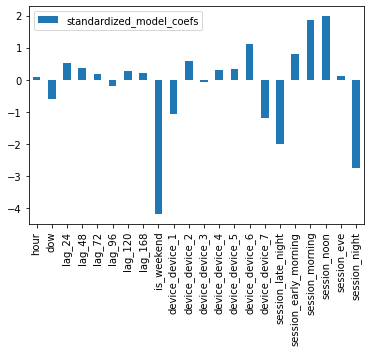

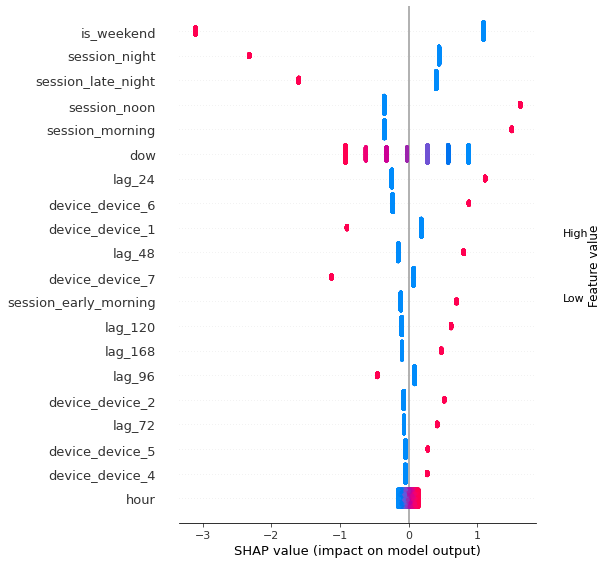

In [59]:
X_test_5, y_test_5, model_5, explainer_5 = train_model(data, std_cols=["hour", "dow"]+data.filter(like='lag_').columns.tolist(), 
                                                             dummy_cols=["is_weekend"]+data.filter(like='device_').columns.tolist() +
                                                                                       data.filter(like='session_').columns.tolist())

Classification Stats for Device: device_1

              precision    recall  f1-score   support

           0       0.97      0.85      0.90       516
           1       0.47      0.85      0.61        84

    accuracy                           0.85       600
   macro avg       0.72      0.85      0.76       600
weighted avg       0.90      0.85      0.86       600



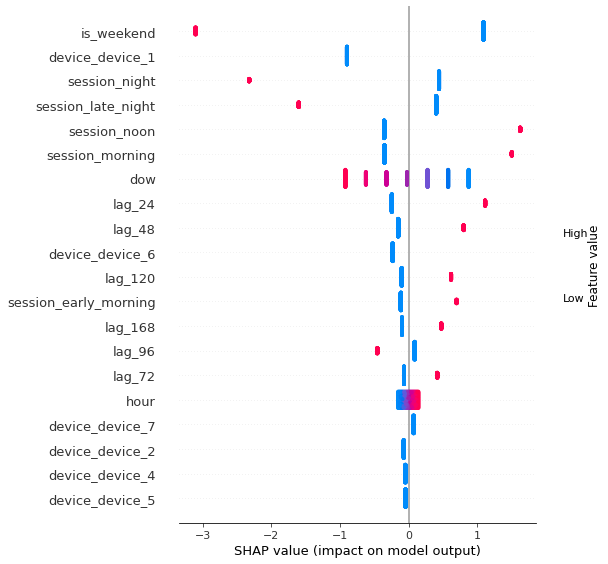


Classification Stats for Device: device_2

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       431
           1       0.88      0.86      0.87       169

    accuracy                           0.93       600
   macro avg       0.92      0.91      0.91       600
weighted avg       0.93      0.93      0.93       600



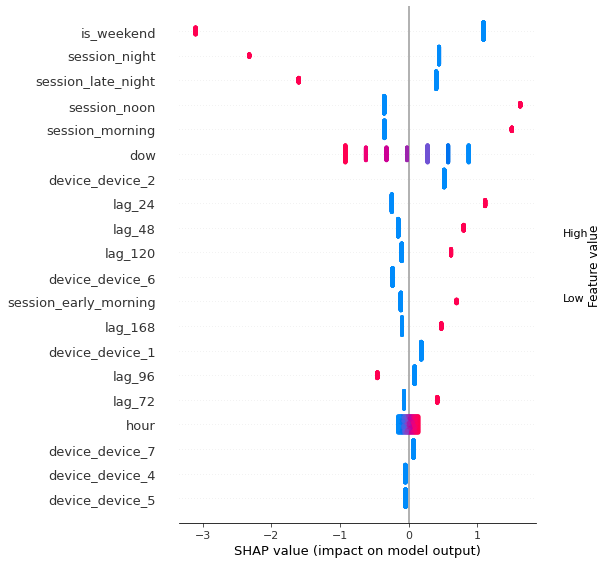


Classification Stats for Device: device_3

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       529
           1       0.45      0.51      0.48        71

    accuracy                           0.87       600
   macro avg       0.69      0.71      0.70       600
weighted avg       0.88      0.87      0.87       600



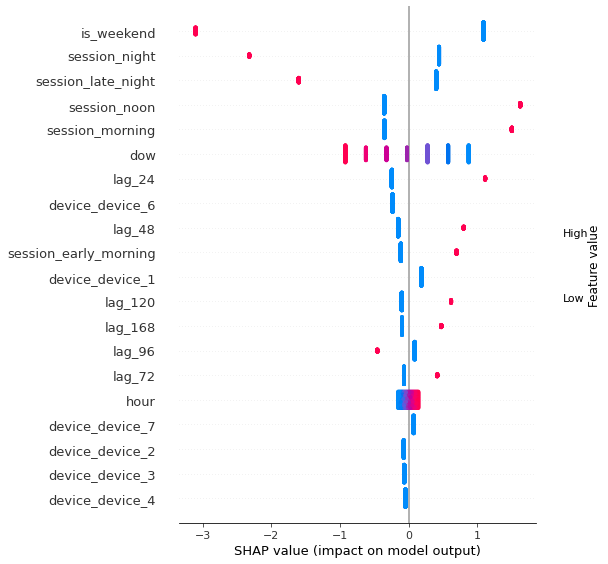


Classification Stats for Device: device_4

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       514
           1       0.61      0.49      0.54        86

    accuracy                           0.88       600
   macro avg       0.76      0.72      0.74       600
weighted avg       0.87      0.88      0.88       600



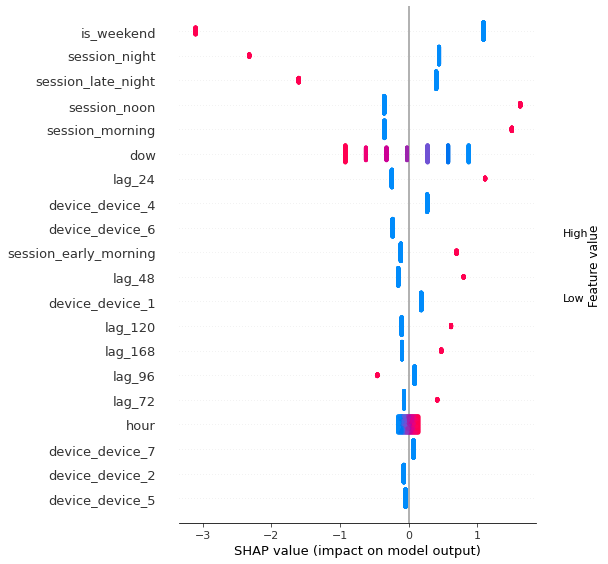


Classification Stats for Device: device_5

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       487
           1       0.59      0.50      0.55       113

    accuracy                           0.84       600
   macro avg       0.74      0.71      0.72       600
weighted avg       0.83      0.84      0.84       600



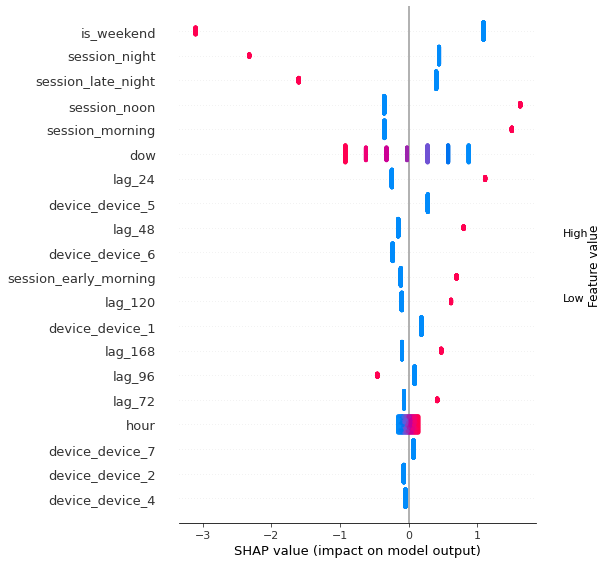


Classification Stats for Device: device_6

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       384
           1       0.94      0.86      0.90       216

    accuracy                           0.93       600
   macro avg       0.93      0.91      0.92       600
weighted avg       0.93      0.93      0.93       600



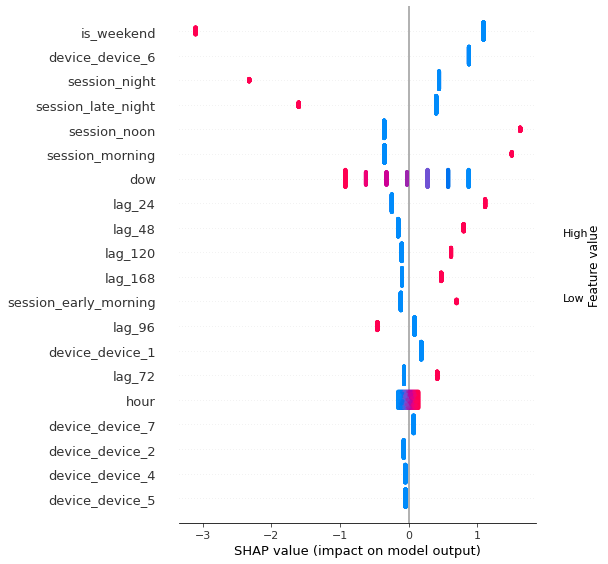


Classification Stats for Device: device_7

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       599
           1       0.00      0.00      0.00         1

    accuracy                           0.97       600
   macro avg       0.50      0.48      0.49       600
weighted avg       1.00      0.97      0.98       600



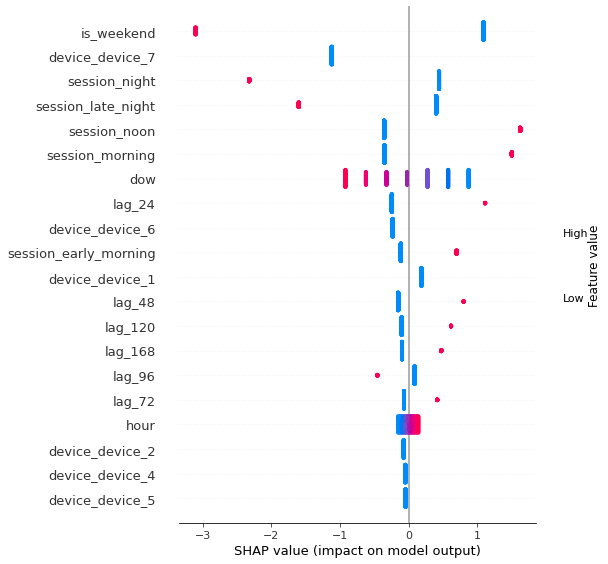

In [60]:
for dev in df_dict.keys():
    
    print(f"Classification Stats for Device: {dev}\n")
    
    X_test_dev = X_test_5[X_test_5[f"device_{dev}"] == 1]
    y_test_dev = y_test_5.loc[X_test_dev.index]
                    
    pred = model_5.predict(X_test_dev)

    print(classification_report(pred, y_test_dev))
    
    shap_values = explainer_5(X_test_dev)
    shap_values1 = shap_values.values.astype(np.float)
    
    shap.summary_plot(shap_values1, X_test_dev)
    
    print()